In [1]:
%matplotlib inline
import pyart
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

/short/en0/vhl548/miniconda3/envs/radar/lib/python3.7/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/short/en0/vhl548/miniconda3/envs/radar/lib/python3.7/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/short/en0/vhl548/miniconda3/envs/radar/lib/python3.7/site-packages/heapdict.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class heapdict(collections.MutableMapping):


In [2]:
# Load radar data
dtime = pd.to_datetime("2016-10-21T20:20:00")

date = dtime.strftime('%Y%m%d')
time = dtime.strftime('%H%M')
infile = f'/g/data/hj10/cpol_level_1b/v2019/ppi/{dtime.year}/{date}/twp10cpolppi.b1.{date}.{time}00.nc'
radar = pyart.io.read(infile)

In [3]:
def check_dimensions(radar, field='corrected_reflectivity'):
    """
    Check if field dimensions are constants across elevations
    """
    dim0 = radar.fields[field]['data'][radar.get_slice(0)].shape
    for ns in range(1, radar.nsweeps):
        if dim0 != radar.fields[field]['data'][radar.get_slice(ns)].shape:
            raise ValueError("dimension mismatch.")
    return True

In [4]:
cappi_altitude = 2500  # Altitude in m for the CAPPI

In [5]:
# Reshape field into a 3D array (elevation, azimuth, range)
if check_dimensions(radar):
    refl = radar.fields['corrected_reflectivity']['data'].copy()
    dim0 = refl[radar.get_slice(0)].shape

    ref3dorig = refl.reshape((radar.nsweeps, dim0[0], dim0[1]))
    ref3d = np.zeros_like(ref3dorig)
    
    # Sorting azimuth, put azimuth 0 at index 0, second azimuth at index 1, ...
    for ns in range(radar.nsweeps):
        azi = radar.azimuth['data'][radar.get_slice(ns)]
        pos = np.argsort(azi)    
        for i, p in enumerate(pos):
            ref3d[ns, i, :] = ref3dorig[ns, p, :].copy()

In [6]:
elevation = np.unique(radar.elevation['data'])
r = radar.range['data']
azi = np.linspace(0, 359, dim0[0])

# Convert azimuth to polar
theta = (450 - azi)
theta[theta >= 360] -= 360

THETA, PHI, R = np.meshgrid(theta, elevation, r)

# Radar spherical to cartesian
X = R * np.cos(PHI * np.pi / 180) * np.cos(THETA * np.pi / 180)
Y = R * np.cos(PHI * np.pi / 180) * np.sin(THETA * np.pi / 180)
Z = R * np.sin(PHI * np.pi / 180)

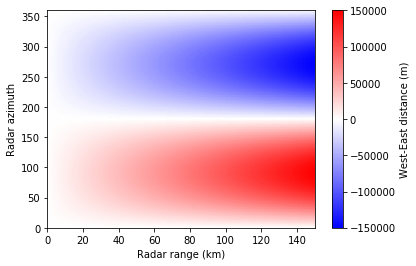

In [7]:
pl.imshow(X[0, :, :], extent=[0, 150, 0, 360], origin='ij', aspect='auto', cmap='bwr')
pl.colorbar(label='West-East distance (m)')
pl.xlabel('Radar range (km)')
pl.ylabel('Radar azimuth')
pl.show()

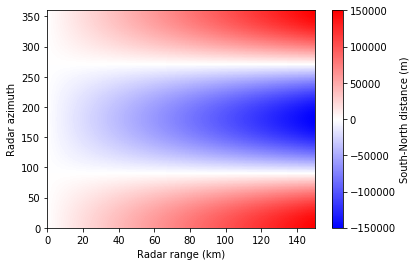

In [8]:
pl.imshow(Y[0, :, :], extent=[0, 150, 0, 360], origin='ij', aspect='auto', cmap='bwr')
pl.colorbar(label='South-North distance (m)')
pl.xlabel('Radar range (km)')
pl.ylabel('Radar azimuth')
pl.show()

In [9]:
posslice = np.argmin(np.abs(Z - cappi_altitude), axis=0)

CAPPI = np.zeros((dim0[0], dim0[1]))
XC = np.zeros((dim0[0], dim0[1]))
YC = np.zeros((dim0[0], dim0[1]))
for i in range(dim0[1]):
    for j in range(dim0[0]):
        CAPPI[j, i] = ref3d[posslice[j, i], j, i]
        XC[j, i] = X[posslice[j, i], j, i]
        YC[j, i] = Y[posslice[j, i], j, i]

/short/en0/vhl548/miniconda3/envs/radar/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Warning: converting a masked element to nan.
  


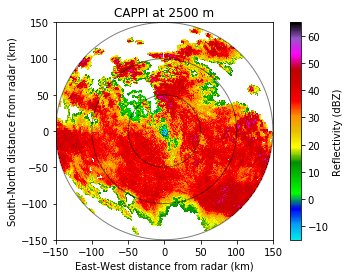

In [10]:
fig, ax = pl.subplots(1, 1)
im = ax.pcolormesh(XC / 1e3, YC / 1e3, CAPPI, cmap='pyart_NWSRef', vmin=-15, vmax=65)
fig.colorbar(im, ax=ax, label='Reflectivity (dBZ)')
[ax.plot(r * np.cos(theta * np.pi / 180), r * np.sin(theta * np.pi / 180), 'k', linewidth=1, alpha=0.5) for r in [50, 100, 150]]
ax.set_aspect(1)
ax.set_xlabel('East-West distance from radar (km)')
ax.set_ylabel('South-North distance from radar (km)')
ax.set_title(f'CAPPI at {cappi_altitude} m')
pl.show()